<a href="https://colab.research.google.com/github/uyangas/Visualizations-in-Python/blob/main/Google_play_store_app_seaborn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Play Store App Data Visualization (Seaborn)

https://www.kaggle.com/lava18/google-play-store-apps

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 3.1MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.10-cp36-none-any.whl size=73269 sha256=a80b0f3ee60ef05c5e98d0ef1c44376e51d680d885875545e5a1800383d8499e
  Stored in directory: /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10
Successfully built kaggle
  Found existing installation: kaggle 1.5.10
    Uninstalling kaggle-1.5.10:
      Successfully uninstalled kaggle-1.5.10


## 1. Download the datasets

In [ ]:
from google.colab import files
files.upload()

In [3]:
!mkdir ~/.kaggle

In [4]:
# save kaggle.json to "kaggle" directory
! cp kaggle.json ~/.kaggle/

In [5]:
# change the permission of the file
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
# download the dataset
! kaggle datasets download -d lava18/google-play-store-apps --force

  0% 0.00/1.94M [00:00<?, ?B/s]
100% 1.94M/1.94M [00:00<00:00, 64.9MB/s]


In [7]:
# create directory to unzip the data
! mkdir ~/.google_play_store

In [8]:
! unzip google-play-store-apps.zip -d google_play_store

Archive:  google-play-store-apps.zip
  inflating: google_play_store/googleplaystore.csv  
  inflating: google_play_store/googleplaystore_user_reviews.csv  
  inflating: google_play_store/license.txt  


In [9]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from scipy.stats import linregress
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, ImageColorGenerator
import re

warnings.filterwarnings('ignore')
%matplotlib inline

## 2. Data preprocessing

In [12]:
ps = pd.read_csv("google_play_store/googleplaystore.csv")
review = pd.read_csv("google_play_store/googleplaystore_user_reviews.csv")
ps.head()

App  ...   Android Ver
0     Photo Editor & Candy Camera & Grid & ScrapBook  ...  4.0.3 and up
1                                Coloring book moana  ...  4.0.3 and up
2  U Launcher Lite – FREE Live Cool Themes, Hide ...  ...  4.0.3 and up
3                              Sketch - Draw & Paint  ...    4.2 and up
4              Pixel Draw - Number Art Coloring Book  ...    4.4 and up

[5 rows x 13 columns]

In [13]:
print(f"The size of the play store dataset: {ps.shape}, The size of the review dataset: {review.shape}")

The size of the play store dataset: (10841, 13), The size of the review dataset: (64295, 5)


In [14]:
ps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


The imported data type of some of the variables such as `Price` and `Reviews` were objects. To perform calculations on some of the variables, `Price` was converted to numerical `float` value after `$` was removed, `Reviews` was converted to `int` and `Last Updated` was converted to `datetime` data type.

In [15]:
def change_datatype(df):
  '''
  Fixes column problem of a data point and converts the columns to corresponding datatypes

  params: dataframe
  outcome: dataframe

  '''

  values = list(df.iloc[10472,:])
  values.insert(1, values.pop(12))
  df.iloc[10472,:] = values

  df['Price'] = df['Price'].str.strip('$').astype('float')
  df['Reviews'] = df['Reviews'].astype('int')

  df['Last Updated'] = pd.to_datetime(df['Last Updated'])

  return df

In [16]:
ps = change_datatype(ps)
ps.head()

App  ...   Android Ver
0     Photo Editor & Candy Camera & Grid & ScrapBook  ...  4.0.3 and up
1                                Coloring book moana  ...  4.0.3 and up
2  U Launcher Lite – FREE Live Cool Themes, Hide ...  ...  4.0.3 and up
3                              Sketch - Draw & Paint  ...    4.2 and up
4              Pixel Draw - Number Art Coloring Book  ...    4.4 and up

[5 rows x 13 columns]

In the `ps` dataset, app names were duplicated. Total of 798 apps were duplicated. Some of the apps belonged to 2 categories or the number of reviews differed a bit. Therefore, to remove the duplicated values, the first values of each duplicated app was taken.

In [17]:
duplicated = ps[['App','Category']].groupby('App').count().sort_values(ascending=False, by='Category').reset_index().rename({"Category":"Number of duplications"},axis=1)
duplicated[duplicated['Number of duplications']>1].head()

App  Number of duplications
0                                             ROBLOX                       9
1  CBS Sports App - Scores, News, Stats & Watch Live                       8
2                     Duolingo: Learn Languages Free                       7
3                                               ESPN                       7
4                                        8 Ball Pool                       7

In [18]:
df = pd.DataFrame()
for row in duplicated[duplicated['Number of duplications']>1]['App'].values:
  df = pd.concat([df, ps[ps['App'] == row].iloc[0,:]], axis=1)

In [19]:
df = df.T
ps = ps.loc[[True if row not in duplicated[duplicated['Number of duplications']>1]['App'].values else False for row in ps['App']],:]
ps = pd.concat([ps, df], axis=0)
ps.reset_index(inplace=True)

del df, duplicated

`Rating` had 1463 `NA` values which were not removed. `NA` values were ignored in the calculations.

In [20]:
ps.isna().sum()

index                0
App                  0
Category             1
Rating            1463
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       0
Genres               1
Last Updated         0
Current Ver          8
Android Ver          2
dtype: int64

In [21]:
ps = ps[~ps.Rating.isna()].astype({'Rating':'float'})

In [22]:
ps['Size'] = [float(i.strip('k'))/1024 if i.find('k') > 0 else i.strip('M') for i in ps.Size]
ps['Size'] = ps['Size'].replace('Varies with device',0).astype('float')

In [23]:
ps['review_perc'] = ps['Reviews']/ ps['Installs'].str.replace('+',"").str.replace(',',"").astype('int')

`review` dataset contains the review text and the sentiments of the reviews. 

In [24]:
review.head()

App  ... Sentiment_Subjectivity
0  10 Best Foods for You  ...               0.533333
1  10 Best Foods for You  ...               0.288462
2  10 Best Foods for You  ...                    NaN
3  10 Best Foods for You  ...               0.875000
4  10 Best Foods for You  ...               0.300000

[5 rows x 5 columns]

`review` dataset contains rows with many `NA` values. 41.7% of the rows didn't have any values. These rows were dropped.

In [25]:
review.isna().sum()

App                           0
Translated_Review         26868
Sentiment                 26863
Sentiment_Polarity        26863
Sentiment_Subjectivity    26863
dtype: int64

In [26]:
review.dropna(inplace=True)
print(f"Shape of review dataset after NAs dropped: {review.shape}")

Shape of review dataset after NAs dropped: (37427, 5)


The number of apps in `review` dataset is less than that was in `ps` dataset. 1020 apps had reviews.

In [27]:
print(f"Total number of apps: {len(ps['App'].unique())}")
print(f"Number of apps with reviews: {len(review['App'].unique())}")
print(f"Number of apps with reviews available: {len(np.intersect1d(review['App'].unique(), ps['App'].unique()))}")

Total number of apps: 8197
Number of apps with reviews: 865
Number of apps with reviews available: 816


In [28]:
# stemmer = PorterStemmer()
# processed_reviews = []
# for row in review.Translated_Review:
#   row = row.lower()
#   row = word_tokenize(row)
#   row = [re.sub(r"\W"," ", word.strip()) for word in row if (word.isalpha() and len(word)>1)]
#   row = [stemmer.stem(word) for word in row if word not in stopwords.words('english')]
#   processed_reviews.append(" ".join(row))

# review['Translated_Review'] = processed_reviews

## 3. Exploratory Data Analysis

The exploratory data analysis is conducted to offer answers to the following questions.
1. What is the definition of successful app?
2. What makes the app successful?
3. What are the characteristics of the most successful and unsuccessful apps?
4. Do reviews matter and how much it matters?

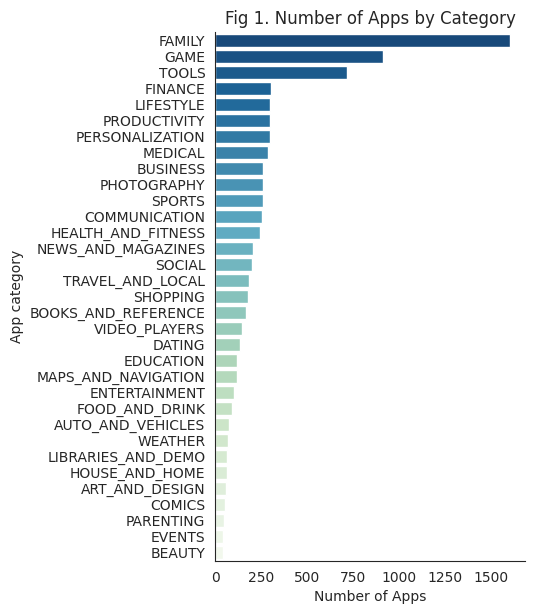

In [105]:
sns.set_style('white')
fig, ax = plt.subplots(figsize=(4,7), dpi=100)
ax = sns.countplot(y='Category', data=ps[['Category','Type']],  
            order=ps[['Category','Type']].groupby('Category').count().sort_values(by='Type',ascending=False).index,
            palette='GnBu_r')
ax.set_title("Fig 1. Number of Apps by Category")
ax.set_xlabel("Number of Apps")
ax.set_ylabel("App category")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

The most apps are `Family` apps and followed by `Game` and `Tools` apps. 

Text(0.5, 1.05, 'Fig 2. Number of Apps by Content Rating')

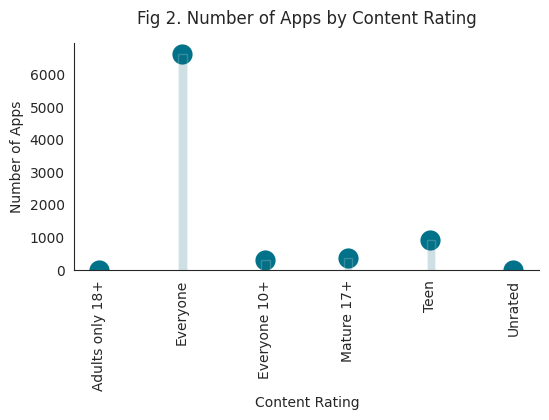

In [109]:
cont_rating = ps.groupby('Content Rating').agg({'App':'count'}).reset_index()

fig, ax = plt.subplots(figsize=(6,3), dpi=100)
sns.barplot(x=cont_rating['Content Rating'], y= cont_rating['App'], ax=ax, color='#017289', alpha=0.2, edgecolor=None)

for bar in ax.patches:
  x = bar.get_x()
  width = bar.get_width()
  centre = x+width/2.
  bar.set_x(centre-width/20.)
  bar.set_width(0.1)

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

sns.scatterplot(x=cont_rating['Content Rating'], y= cont_rating['App'], ax=ax, s=250, color='#017289')

ax.set_ylabel("")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_ylabel("Number of Apps")
ax.set_title("Fig 2. Number of Apps by Content Rating", y=1.05)

The majority of the apps are designed for people of all ages and there are very few apps for `Adults only 18+` and `Mature 17+`.

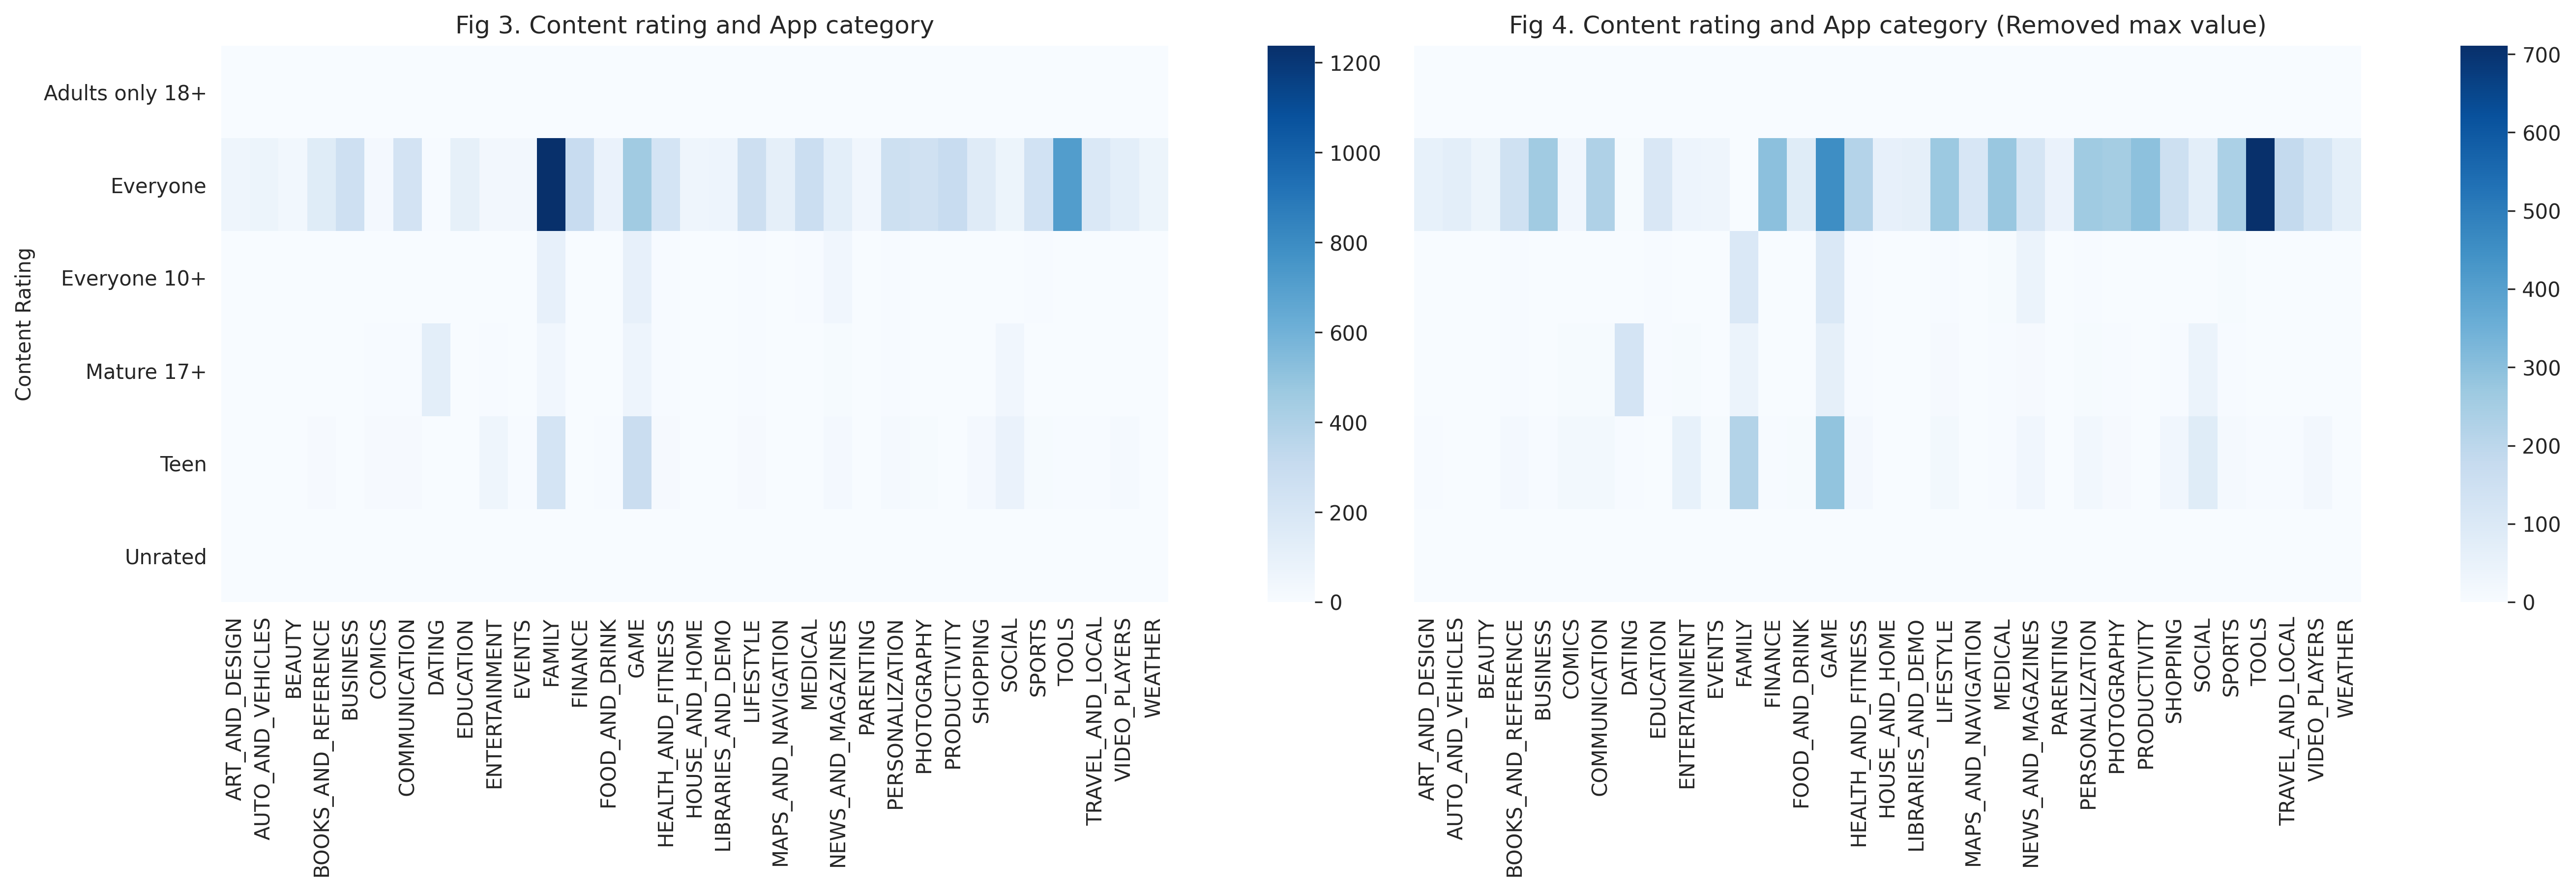

In [110]:
app_cnt = ps.groupby(['Category', 'Content Rating']).agg({'App':'count'}).reset_index().pivot('Content Rating','Category','App').fillna(0)

f,(ax1, ax1cb, ax2, ax2cb) = plt.subplots(1,4, 
            gridspec_kw={'width_ratios':[1,0.05,1,0.05]},
            figsize=(20,5),
            dpi=300)
ax1.get_shared_y_axes().join(ax2)

g1 = sns.heatmap(app_cnt, ax=ax1, cbar_ax=ax1cb, cmap='Blues')

app_cnt.loc['Everyone', 'FAMILY'] = 0

g2 = sns.heatmap(app_cnt, ax=ax2, cbar_ax=ax2cb, cmap='Blues')
g2.set_yticklabels("")
g1.set_xlabel("")
g2.set_xlabel("")
g2.set_ylabel("")
g2.set_yticks([])
g1.set_title("Fig 3. Content rating and App category")
g2.set_title("Fig 4. Content rating and App category (Removed max value)")

for ax in [g1,g2]:
    tl = ax.get_xticklabels()
    ax.set_xticklabels(tl, rotation=90)
    tly = ax.get_yticklabels()
    ax.set_yticklabels(tly, rotation=0)

plt.show()

If we look at the `Category` and `Content Rating` cross heatmap, we can see that `entertainment`, `family`, `gaming` and `social` apps mostly developed for `teens`.

Text(0.5, 1.0, 'Fig 5. Percentage of Paid Apps')

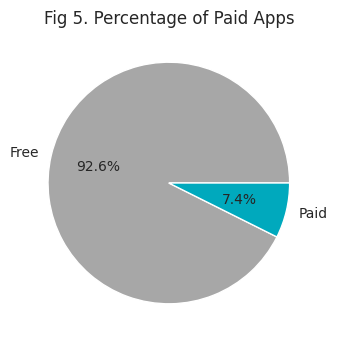

In [111]:
fig, ax = plt.subplots(dpi=100)
ax.pie(dict(ps['Type'].value_counts()).values(), 
       labels =dict(ps['Type'].value_counts()).keys(), 
       autopct='%1.1f%%', 
       colors=['#A7A7A7','#00A9BD'])
fig.show()
ax.set_title("Fig 5. Percentage of Paid Apps")

92.2% of all the apps are free and only 7.8% are paid apps. 

Text(0, 0.5, '')

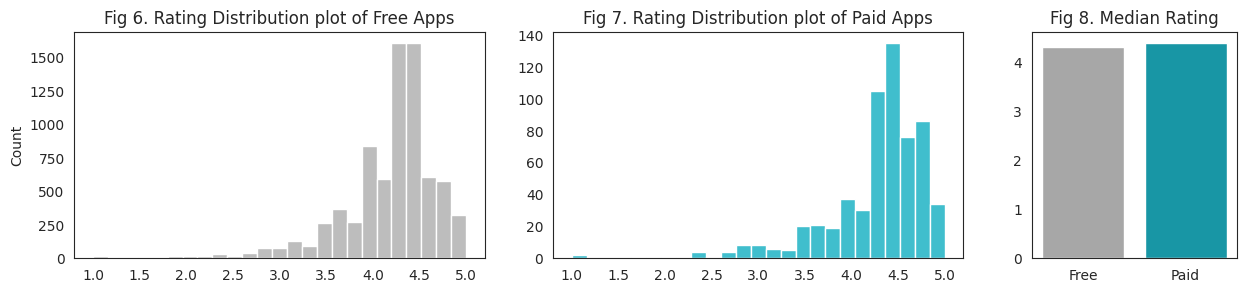

In [118]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, 
                                    figsize=(15,3),
                                    gridspec_kw={'width_ratios':[2,2,1]},
                                    dpi=100)

sns.histplot(x='Rating', data=ps[ps['Type'] == 'Free'], 
             ax=ax1, 
             color='#A7A7A7',
             bins=25)
sns.histplot(x='Rating', data=ps[ps['Type'] == 'Paid'], 
             ax=ax2, 
             color='#00A9BD',
             bins=25)
sns.barplot(x='Type', y='Rating', data=ps, 
                ci=False, estimator=np.median,
            ax=ax3,
            palette=['#A7A7A7','#00A9BD'])

ax1.set_title("Fig 6. Rating Distribution plot of Free Apps")
ax2.set_title("Fig 7. Rating Distribution plot of Paid Apps")
ax3.set_title("Fig 8. Median Rating")
ax1.set_xlabel("")
ax2.set_xlabel("")
ax2.set_ylabel("")
ax3.set_xlabel("")
ax3.set_ylabel("")

If we look at the `Rating` of free and paid apps, they both have similar median ratings, free apps - 4.3 and paid apps - 4.4. Since the distribution of rating is left skewed, the median was used from here on after when comparisons were made.

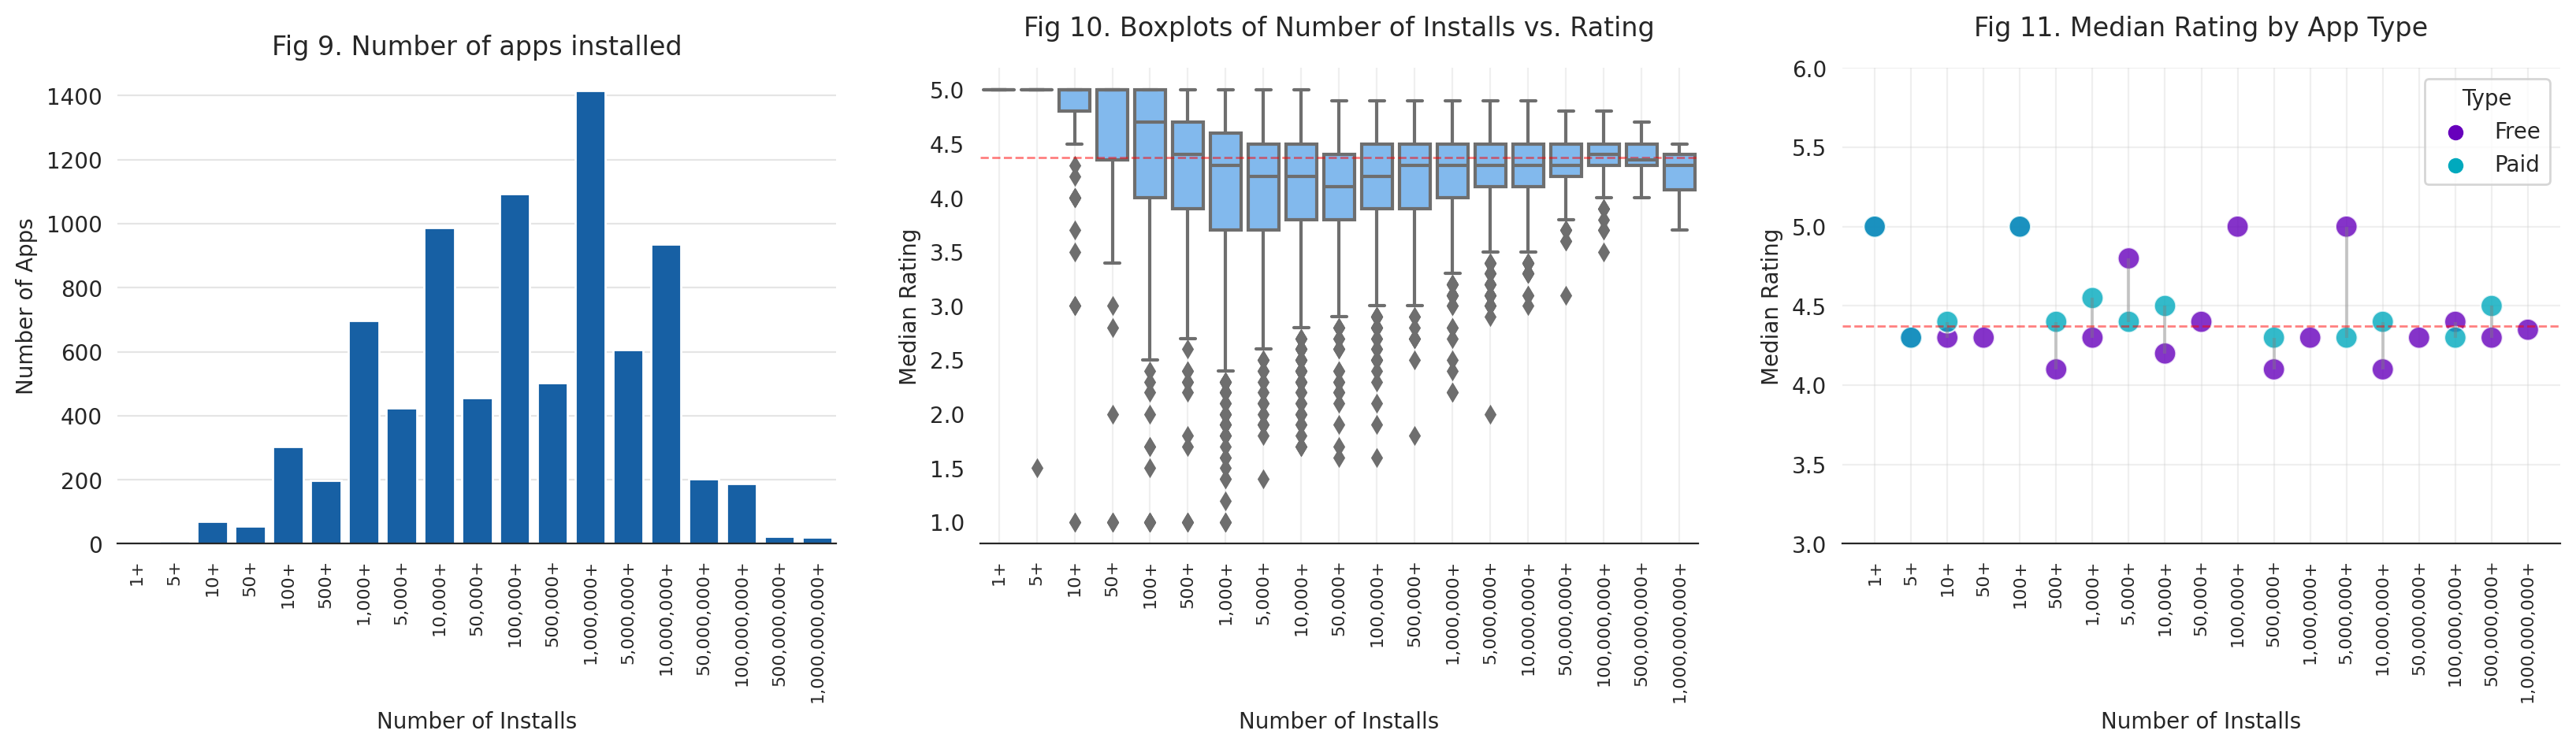

In [122]:
order_app = ['1+', '5+','10+','50+','100+', '500+','1,000+','5,000+',
             '10,000+','50,000+','100,000+','500,000+','1,000,000+','5,000,000+',
             '10,000,000+', '50,000,000+', '100,000,000+','500,000,000+', '1,000,000,000+']

installs = ps.groupby(['Installs','Type']).agg({'Rating':'median'}).reset_index()
installs_diff = installs.groupby('Installs').agg({'Rating':'max'})
installs_diff['min'] = installs.groupby('Installs').agg({'Rating':'min'}).Rating

fig, (ax1, ax0, ax) = plt.subplots(1,3, figsize=(20,4), dpi=200)
sns.scatterplot(x='Installs',
                y='Rating',
                data =installs,
                hue='Type',
                palette=['#6700BC', '#00A9BD'],
                s=100,
                alpha=0.8,
                ax=ax)

ax.vlines(x=installs_diff.index, 
          ymin=installs_diff['min'], 
          ymax=installs_diff['Rating'], 
          color='grey', 
          alpha=0.4)

ax.axhline(installs.Rating.median(), color='red', alpha=0.5, linestyle='--', linewidth=1)

ax.set_xticklabels(order_app,rotation=90, fontsize=8)
ax.set_xlabel("Number of Installs")
ax.set_ylabel("Median Rating")
ax.set_ylim(3,6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_title("Fig 11. Median Rating by App Type", y=1.04)
ax.yaxis.grid(True, alpha=0.3)
ax.xaxis.grid(True, alpha=0.3)

sns.boxplot(x='Installs', 
            y='Rating', 
            data=ps, 
            ax=ax0, 
            order=order_app,
            color='#70BAFF')

ax0.set_xticklabels(order_app, rotation=90, fontsize=8)
ax0.set_xlabel("Number of Installs")
ax0.set_ylabel("Median Rating")
ax0.set_title("Fig 10. Boxplots of Number of Installs vs. Rating", y=1.04)
ax0.axhline(installs.Rating.median(), color='red', alpha=0.5, linestyle='--', linewidth=1)
ax0.xaxis.grid(True, alpha=.3)
ax0.spines['top'].set_visible(False)
ax0.spines['left'].set_visible(False)
ax0.spines['right'].set_visible(False)


sns.countplot('Installs', data=ps, ax=ax1, order=order_app, color='#0061BB')
ax1.set_xticklabels(order_app, rotation=90, fontsize=8)
ax1.set_title('Fig 9. Number of apps installed')
ax1.set_xlabel("Number of Installs")
ax1.set_ylabel('Number of Apps')
ax1.yaxis.grid(True, alpha=0.5)
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['right'].set_visible(False)

Apps with very few installs, less than 1000, tend to have greater than overall median rating which could be due to few number of reviews and rating and possibly that the ratings were giving not by the actual target users. The range of the highest and the lowest ratings were the greatest for these apps.

Median app ratings went down between 1000 and 100,000 installs. This suggests that the apps starts to get recognition as the number of users who review the apps increases. During this stage, the apps usually update, fix and create features and contents to gain more users. The gap between the highest and the lowest ratings were closer compared to the apps with very few installs.

As for apps with over 500,000 installs, the median ratings went to up and ultimately reached the overall median level. The gap between the highest and the lowest ratings got smaller. This suggests that the mode installs the app has, the more stable it becomes which means less bad review and ratings.  

As the number of installs grows, meaning as the app becomes popular, the rating gap between free and paid apps gets smaller. For apps that have less than 10,000 installs, the gap between free and paid is greater than those apps with higher number of installs. This suggests that as the app gets popular, so does the quality of the programs and contents.

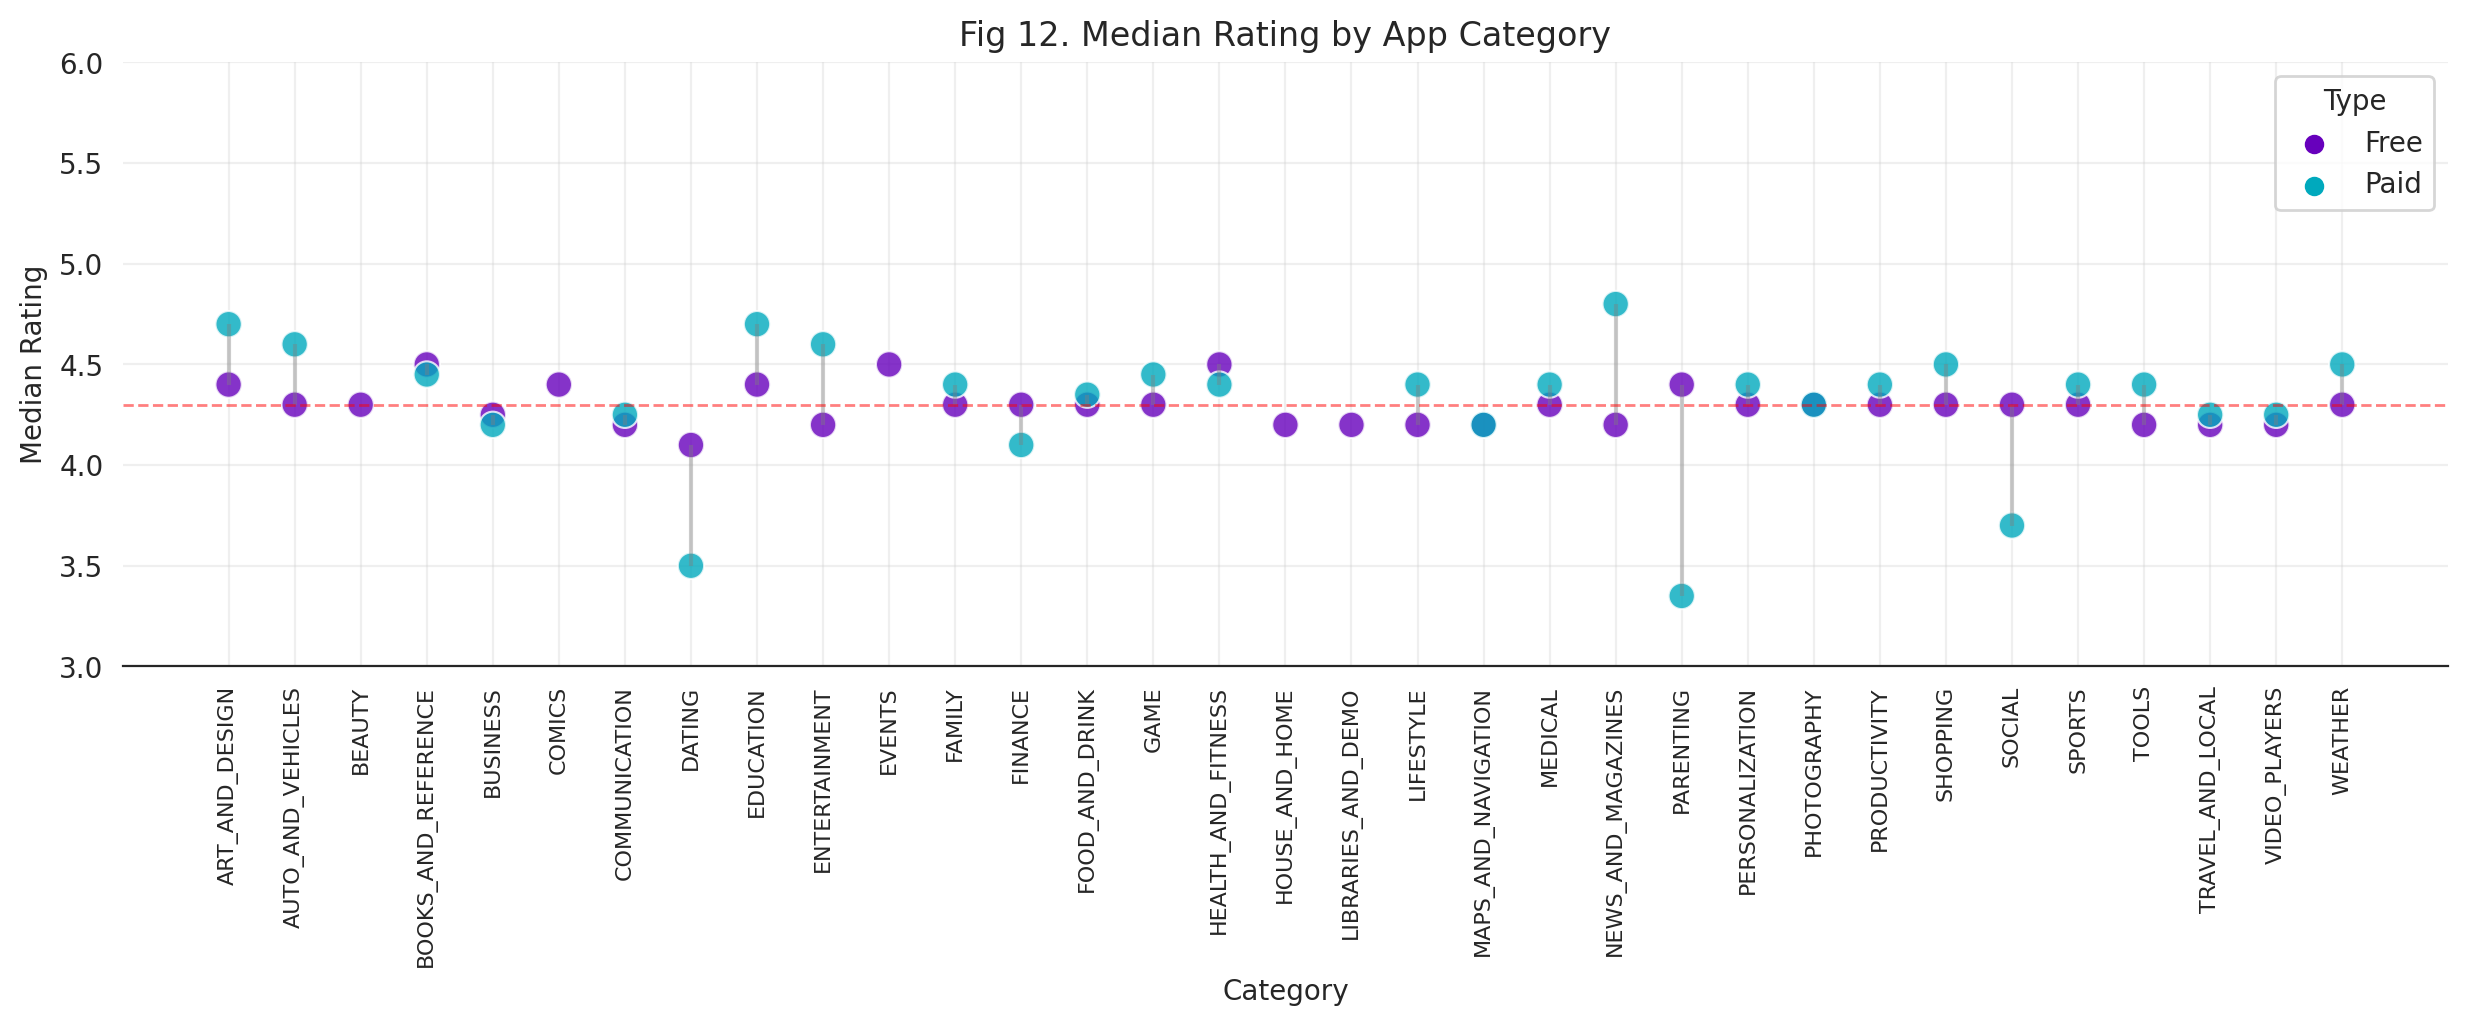

In [123]:
cat_rating = ps.groupby(['Category','Type']).agg({'Rating':'median'}).reset_index()
cat_rating_diff = cat_rating.groupby('Category').agg({'Rating':'max'})
cat_rating_diff['min'] = cat_rating.groupby('Category').agg({'Rating':'min'}).Rating

fig, ax = plt.subplots(figsize=(15,4), dpi=200)
sns.scatterplot(x='Category',
                y='Rating',
                data =cat_rating,
                hue='Type',
                palette=['#6700BC', '#00A9BD'],
                s=90,
                alpha=0.8,
                ax=ax)

ax.vlines(x=cat_rating_diff.index, 
          ymin=cat_rating_diff['min'], 
          ymax=cat_rating_diff['Rating'], 
          color='grey', 
          alpha=0.4)

ax.axhline(cat_rating.Rating.median(), color='red', alpha=0.5, linestyle='--', linewidth=1)

ax.set_xticklabels(cat_rating_diff.index, rotation=90, fontsize=8)
ax.set_xlabel("Category")
ax.set_ylabel("Median Rating")
ax.set_title("Fig 12. Median Rating by App Category")
ax.set_ylim(3,6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.grid(True, alpha=.3)
ax.xaxis.grid(True, alpha=.3)

`Beauty`, `Comics`, `House and home` and `Libraries and demo` categories didn't have any paid apps. 

`Dating`, `Finance`, `Parenting` and `Social` categories have lower median rating for paid apps compared to the free ones. 

`Business`, `Communication`, `Maps and navigation`, `Travel and local` and `Video Players` categories have median app rating below overall median rating.

Other categories have above overal median rating ratings. 

Text(0.5, 0.98, 'Fig 13. App Size vs. Rating')

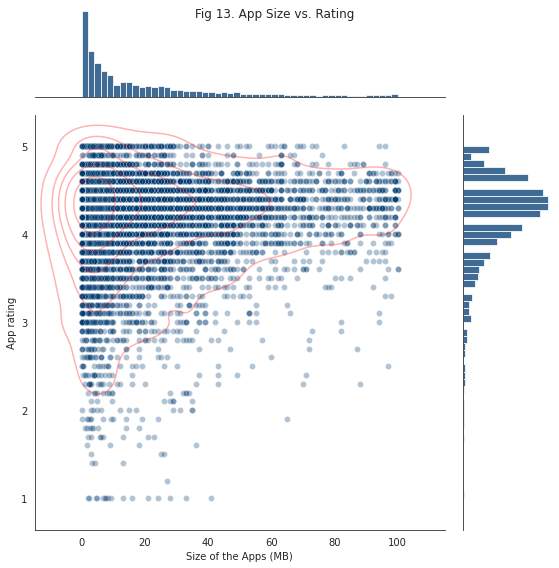

In [124]:
g = sns.jointplot('Size', 
              'Rating', 
              data=ps, 
              alpha=.3, 
              kind='scatter',
              color='#003A71',
              marginal_kws=dict(rug=True, bins=50),
              height=8, ratio=4)

g.plot_joint(sns.kdeplot, color="r", zorder=1, levels=6, alpha=0.3)
g.set_axis_labels(xlabel="Size of the Apps (MB)",
                  ylabel='App rating')
g.fig.suptitle("Fig 13. App Size vs. Rating")

The most apps have a size of less than 10MB. App size doesn't directly correlate with the App rating. Let's see app size difference by app category.

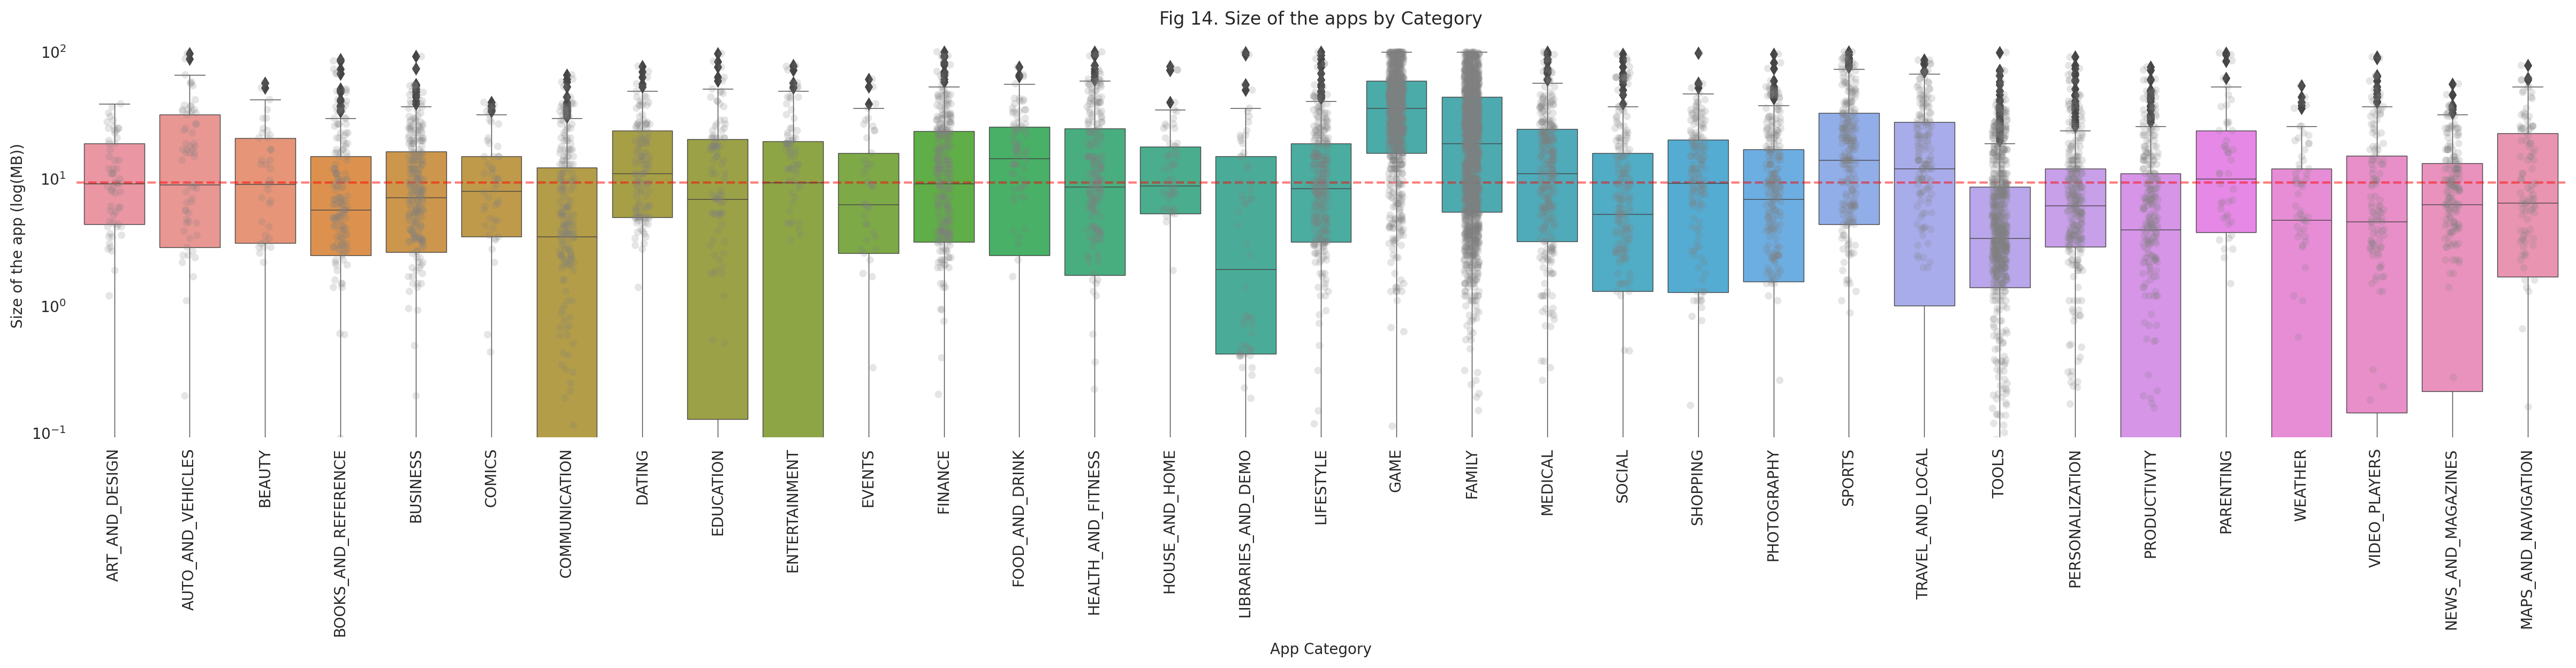

In [265]:
fig, ax = plt.subplots(figsize=(30,5), dpi=200)
ax = sns.boxplot(x='Category', y='Size', data=ps, linewidth=0.5)
ax = sns.stripplot('Category', 'Size', data=ps, alpha=0.2, color='grey')
ax.axhline(ps.Size.median(), color='red', linestyle='--', alpha=0.5)
ax.set_xticklabels(ps.Category.unique(), rotation=90)
ax.set_title("Fig 14. Size of the apps by Category")
ax.set_ylabel("Size of the app (log(MB))")
ax.set_xlabel("App Category")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.yscale('log')

`Communication`, `Education`, `Entertainment`, `Productivity`, `Weather`, `Video Player`, `News and magazine` apps have smaller size compared to the other types of apps. `Dating`, `Game`, `Family`, `Sports` apps have overall bigger app sizes compared to the other types of apps. 

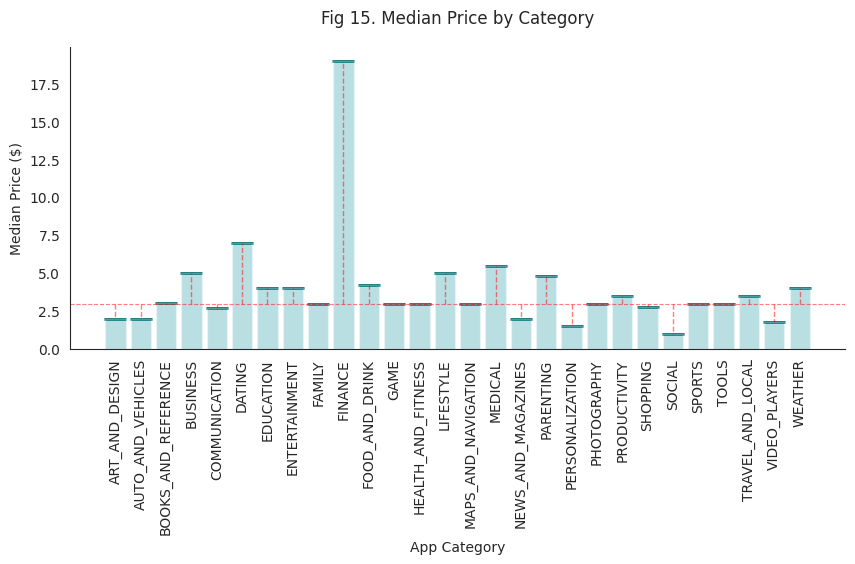

In [126]:
ps['Price'] = ps['Price'].astype('float')
price_median = ps[ps.Price>0].groupby(['Category']).agg({'Price':'median'}).reset_index()

fig, ax = plt.subplots(figsize=(10,4), dpi=100)
sns.scatterplot(x='Category', 
            y='Price', 
            data=price_median,  
            marker= '_',
            s=240,
            color='#006A6A',
            ax=ax,
            linewidth=2)
ax.set_xticklabels(price_median.Category.unique(), rotation=90)
ax.axhline(price_median.Price[price_median.Price > 0].median(), color='red', linestyle='--', alpha=0.5, linewidth=0.8)

sns.barplot(x='Category', 
            y='Price', 
            data=price_median,  
            ax=ax,
            alpha=0.3,
            color='#00A9BD')

ax.vlines(x=price_median.Price[price_median.Price > 0].index,
          ymin=price_median.Price[price_median.Price > 0].median(),
          ymax=price_median.Price,
          color='red', 
          linestyle='--', 
          alpha=0.5, 
          linewidth=1)

ax.set_title("Fig 15. Median Price by Category", y=1.05)
ax.set_ylabel("Median Price ($)")
ax.set_xlabel("App Category")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

Overal median price of the apps is `$2.99`. Now, if we look at the prices of paid apps, `Finance` apps have the highest median price `$18.99` followed by `Business` - `$4.99`, `Dating` - `$6.99`, `Lifestyle` - `$4.99`, `Medical` - `$4.59`, `Parenting` - `$4.79`, `Food and Drink` - `$4.24`. 

`Comic`, `Beauty`, `Events`, `House and Home`, and `Libraries and Demo` apps have no price. 

Below table is the apps with the highest prices.

In [96]:
price_max = {row[1].Category:row[1].Price for row in ps.groupby(['Category']).agg({'Price':'max'}).reset_index().iterrows()}

app_max_price = []
for row in ps.iterrows():
  row_values = row[1]
  
  try:
    if row_values.Price == price_max[row_values.Category]:
      app_max_price.append(True)
    else:
      app_max_price.append(False)
      
  except KeyError:
    app_max_price.append(True)

highest_price = ps[app_max_price]
highest_price[highest_price.Price >0][['App','Category','Price','Installs']].sort_values(by='Category')

App  ...  Installs
3036     X Launcher Prime: With OS Style Theme & No Ads  ...    1,000+
3031  X Launcher Pro - IOS Style Theme & Control Center  ...   10,000+
3027  X Launcher Pro: PhoneX Theme, OS11 Control Center  ...    5,000+
2546                             Ulysse Speedometer Pro  ...   50,000+
7010                      Officiel du SCRABBLE LAROUSSE  ...    5,000+
5008                                 SkyTest BU/GU Lite  ...      500+
6137                        Morse Decoder for Ham Radio  ...    5,000+
3334                       AG Contacts, Premium edition  ...      500+
2598                           K-@ Mail Pro - Email App  ...   10,000+
315   AMBW Dating App: Asian Men Black Women Interra...  ...      100+
9460             Fuzzy Numbers: Pre-K Number Foundation  ...    1,000+
558                                      My Talking Pet  ...  100,000+
2529                             most expensive app (H)  ...      100+
3608                                      I Am Rich Pro  ...    5,000+
3600                                     I am Rich Plus  ...   10,000+
3615                                          I am Rich  ...    5,000+
3619                                 I AM RICH PRO PLUS  ...    1,000+
3610                     I am rich (Most expensive app)  ...    1,000+
3605                                 I am rich(premium)  ...    5,000+
3604                                         I am Rich!  ...    1,000+
3602                                  I Am Rich Premium  ...   50,000+
749                              Paprika Recipe Manager  ...   50,000+
2534                            The World Ends With You  ...   10,000+
8782                                    Fast Tract Diet  ...    1,000+
2671                           I'm Rich - Trump Edition  ...   10,000+
4203                 BackCountry Navigator TOPO GPS PRO  ...  100,000+
9134                          Vargo Anesthesia Mega App  ...    1,000+
7885                          Égalité et Réconciliation  ...      500+
4183                        Baby Connect (activity log)  ...   50,000+
1983                                       BIG Launcher  ...   10,000+
3291                                         NewTek NDI  ...    1,000+
6339    ACCDB MDB DB Manager Pro - Editor for MS Access  ...      500+
6479                                       Penny Finder  ...   10,000+
2999                               W-History Standalone  ...    1,000+
3230                            WhatsFake Pro (Ad free)  ...    5,000+
1706                            Golfshot Plus: Golf GPS  ...   50,000+
2506                                     G-NetTrack Pro  ...    5,000+
7302                         Electrician Calculator Pro  ...    1,000+
2445                      Maps & GPS Navigation OsmAnd+  ...  100,000+
4893                                           BSPlayer  ...   50,000+
8611                            Florida Tides & Weather  ...    1,000+

[41 rows x 4 columns]

In [274]:
app_review = review.groupby(['App','Sentiment']).agg({'Translated_Review':'count'})\
.reset_index()\
.rename({'Translated_Review':'Number_Sentiment'},axis=1)\
.pivot('App','Sentiment','Number_Sentiment').fillna(0)

In [275]:
positive_perc = []
negative_perc = []
neutral_perc = []

# Create percentage of positive, negative, and neutral reviews for each app
for row in app_review.iterrows():
  row_values = row[1]
  positive_perc.append(row_values['Positive']/sum(row_values[['Negative','Neutral','Positive']]))
  negative_perc.append(row_values['Negative']/sum(row_values[['Negative','Neutral','Positive']]))
  neutral_perc.append(row_values['Neutral']/sum(row_values[['Negative','Neutral','Positive']]))

app_review['positive_perc'] = positive_perc
app_review['negative_perc'] = negative_perc
app_review['neutral_perc'] = neutral_perc
app_review.drop(['Negative',	'Neutral',	'Positive'], axis=1, inplace=True)

In [276]:
app_review = pd.merge(ps, app_review, on='App', how='left')

# Create categorical label for Rating
bins = [0, 3.0, 3.5, 4.0, 4.5, np.inf]
labels = ['1. <3.0', '2. 3.0-3.5', '3. 3.5-4.0', '4. 4.0-4.5', '5. 4.5-5.0']

app_review['Rating_Cat'] = pd.cut(app_review.Rating, bins, labels=labels)

In [277]:
app_review['Sentiment_null'] = app_review.positive_perc.isna()
# 
sent_num = app_review.groupby(['Rating_Cat']).agg({'Sentiment_null':'sum', 'Rating':'count'}).reset_index().assign(Sentiment = lambda x: 1-x.Sentiment_null/x.Rating).drop(['Sentiment_null',	'Rating'], axis=1)
#
sent_cat = app_review.groupby(['Category']).agg({'Sentiment_null':'sum', 'Rating':'count'}).reset_index().assign(Sentiment = lambda x: 1-x.Sentiment_null/x.Rating).drop(['Sentiment_null',	'Rating'], axis=1)
# 
total = {'No reviews': app_review.Sentiment_null.sum()/len(app_review.Sentiment_null), 'With reviews':1-app_review.Sentiment_null.sum()/len(app_review.Sentiment_null)}
#
app_review.dropna(inplace=True)
#
sent_num_perc = app_review.groupby(['Rating_Cat']).agg({'positive_perc':'mean',	'negative_perc':'mean',	'neutral_perc':'mean'}).reset_index()
sent_cat_perc = app_review.groupby(['Category']).agg({'positive_perc':'mean',	'negative_perc':'mean',	'neutral_perc':'mean'}).reset_index()

Text(0.5, 1.05, 'Rating Category')

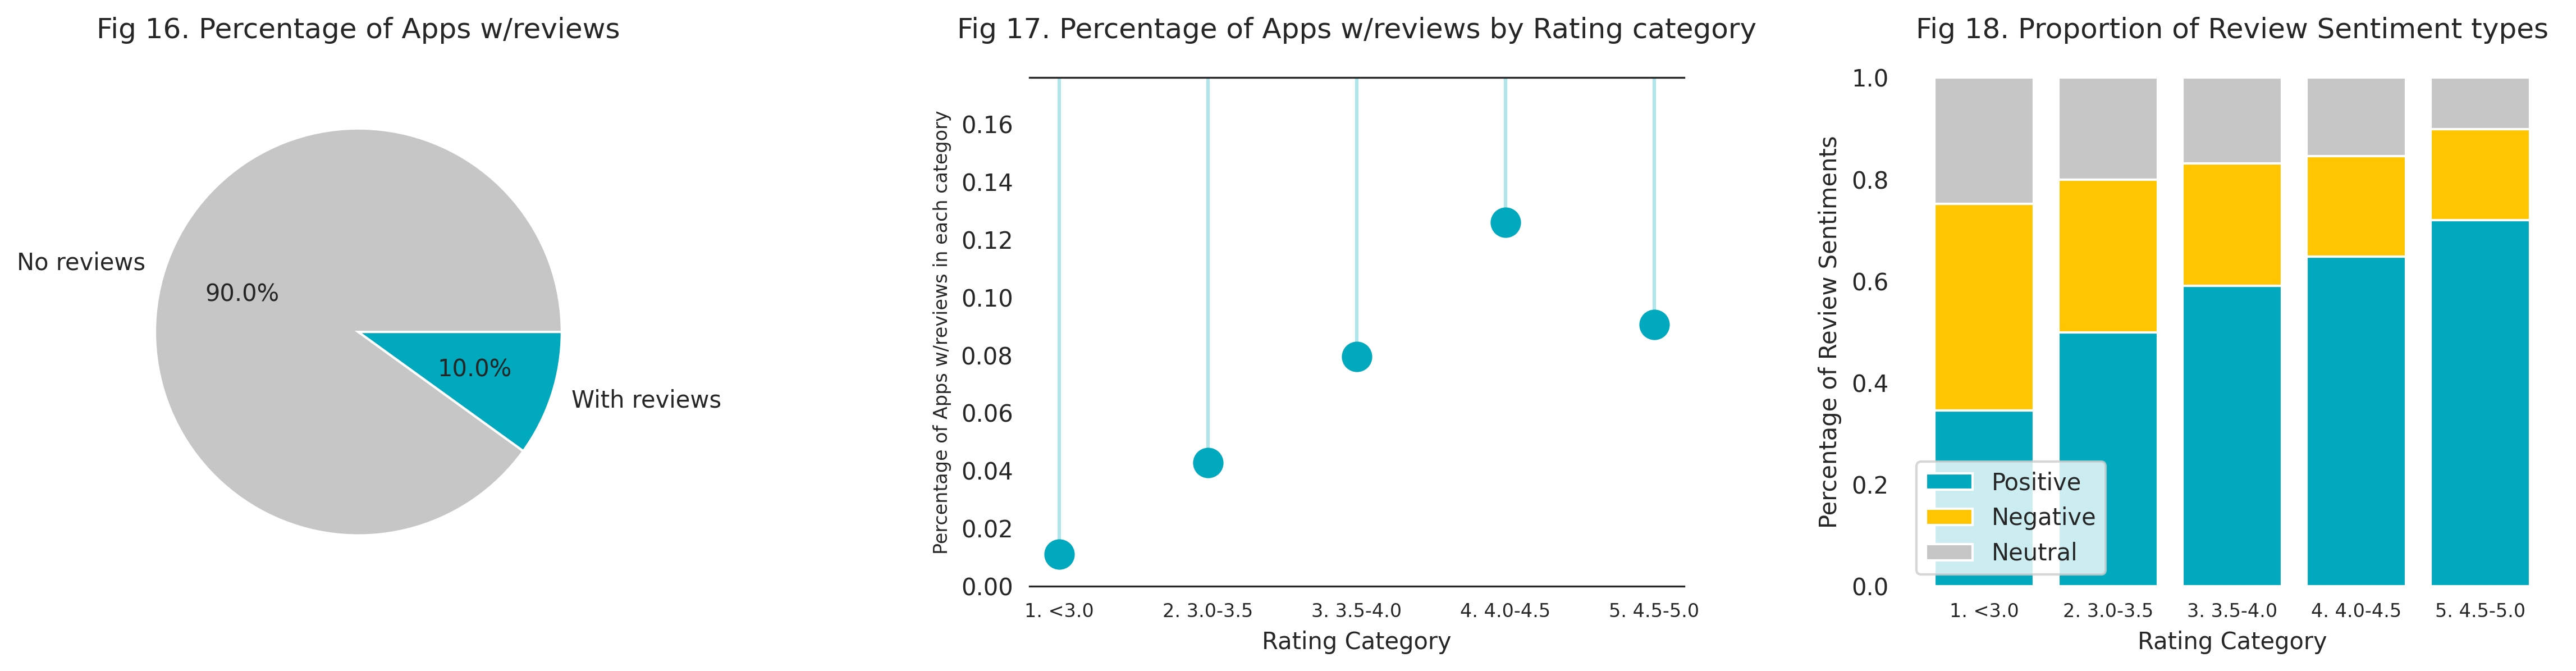

In [269]:
fig, (ax1, ax3,  ax2, ax5, ax4) = plt.subplots(1, 5, 
                               figsize=(20, 4),
                               gridspec_kw={'width_ratios':[1, 0.1, 0.8, 0.05, 0.8]},
                               dpi=300)

ax2.get_shared_y_axes().join(ax4)

ax1.pie(total.values(), labels=total.keys(),
        autopct='%1.1f%%', 
        colors=['#C6C6C6','#00A9BD'])

sns.scatterplot(sent_num.Rating_Cat, 
                sent_num.Sentiment, 
                ax=ax2,
                color='#00A9BD',
                s=200,
                legend=False)

ax4.bar(sent_num_perc.Rating_Cat,
        sent_num_perc.positive_perc,
        label='Positive',
        color='#00A9BD')

ax4.bar(sent_num_perc.Rating_Cat,
        sent_num_perc.negative_perc,
        label='Negative',
        bottom=sent_num_perc.positive_perc,
        color='#FFC500')

ax4.bar(sent_num_perc.Rating_Cat,
        sent_num_perc.neutral_perc,
        label='Neutral',
        bottom=sent_num_perc.positive_perc+sent_num_perc.negative_perc,
        color='#C6C6C6')

ax2.vlines(x = sent_num.Rating_Cat, 
           ymin = sent_num.Sentiment,
           ymax = sent_num.Sentiment.max()+0.05,
           color='#00A9BD',
           alpha=0.3)

ax3.axis('off')
ax3.set_yticklabels([])
ax3.set_xticklabels([])

ax5.axis('off')
ax5.set_yticklabels([])
ax5.set_xticklabels([])

ax1.set_title("Fig 16. Percentage of Apps w/reviews", y=1.05)
ax2.set_title("Fig 17. Percentage of Apps w/reviews by Rating category", y=1.05)
ax2.set_xlabel("Rating Category", y=1.05)
ax2.set_ylabel("Percentage of Apps w/reviews in each category", fontsize=8)
ax2.set_xticklabels(sent_num.Rating_Cat, fontsize=8)
ax2.set_ylim(0, sent_num.Sentiment.max()+0.05)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)

ax4.legend()
ax4.set_ylim(0,1)
ax4.spines['top'].set_visible(False)
ax4.spines['bottom'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.spines['left'].set_visible(False)
ax4.set_xticklabels(sent_num.Rating_Cat, fontsize=8)
ax4.set_title("Fig 18. Proportion of Review Sentiment types", y=1.05)
ax4.set_ylabel("Percentage of Review Sentiments")
ax4.set_xlabel("Rating Category", y=1.05)

Out of 8'197 apps, only 10% of the apps have reviews from the users. Apps with rating between 4.0 and 4.5 have the highest number of reviews. As the rating increases, average number of positive review increases and average number of negative reviews decreases. The higher the rating is, the higher the number of positive reviews.

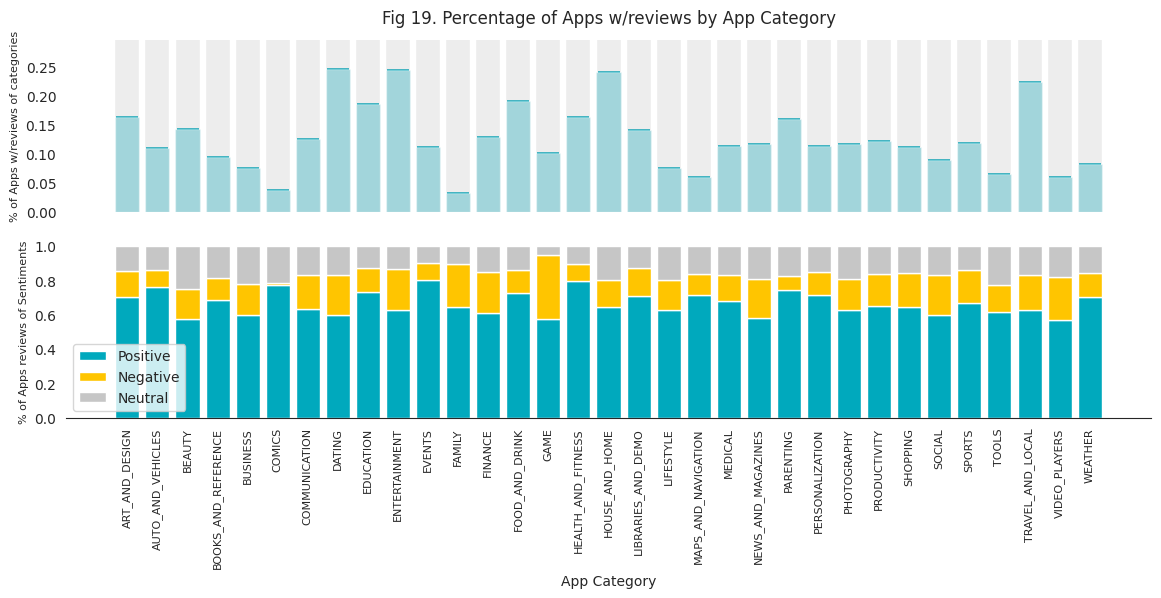

In [332]:
fig, (ax1, ax2) = plt.subplots(2, 1, 
                               figsize=(14, 5),
                               dpi=100)

sns.scatterplot(sent_cat.Category, 
            sent_cat.Sentiment, 
            ax=ax1,
            marker="_",
            s=250,
            color='#00A9BD')

sns.barplot(sent_cat.Category, 
            sent_cat.Sentiment, 
            ax=ax1,
            color='#00A9BD',
            alpha=0.4)

ax1.vlines(x = sent_cat.Category, 
           ymin = sent_cat.Sentiment,
           ymax = sent_cat.Sentiment.max()+0.05,
           color='#A7A7A7',
           alpha=0.2,
           linewidth=17)

ax1.set_xticklabels([])
ax1.set_title("Fig 19. Percentage of Apps w/reviews by App Category", y=1.05)
ax1.set_ylim(0, sent_cat.Sentiment.max()+0.05)
ax1.set_ylabel("% of Apps w/reviews of categories", fontsize=8)
ax1.set_xlabel("")
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)

ax2.bar(sent_cat_perc.Category,
        sent_cat_perc.positive_perc,
        label='Positive',
        color='#00A9BD')

ax2.bar(sent_cat_perc.Category,
        sent_cat_perc.negative_perc,
        label='Negative',
        bottom=sent_cat_perc.positive_perc,
        color='#FFC500')

ax2.bar(sent_cat_perc.Category,
        sent_cat_perc.neutral_perc,
        label='Neutral',
        bottom=sent_cat_perc.positive_perc+sent_cat_perc.negative_perc,
        color='#C6C6C6')

ax2.set_xticklabels(sent_cat_perc.Category, rotation=90, fontsize=8)
ax2.set_ylim(0, 1)
ax2.set_xlabel("App Category")
ax2.set_ylabel("Average % of Reviews Sentiments", fontsize=8)
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.legend()
ax2.grid(axis='x')

Of total number of 
`Dating`, `Entertainment`, `House and Home`, `Travel and Local`, `Education`, `Food and Drink` apps have the highest percentage of reviews. 

In [334]:
sent_cat.sort_values('Sentiment', ascending=False)

Category  Sentiment
7                DATING   0.246269
9         ENTERTAINMENT   0.245098
16       HOUSE_AND_HOME   0.241935
30     TRAVEL_AND_LOCAL   0.224599
13       FOOD_AND_DRINK   0.191489
8             EDUCATION   0.186441
15   HEALTH_AND_FITNESS   0.163934
0        ART_AND_DESIGN   0.163934
22            PARENTING   0.160000
2                BEAUTY   0.142857
17   LIBRARIES_AND_DEMO   0.140625
12              FINANCE   0.129139
6         COMMUNICATION   0.125000
25         PRODUCTIVITY   0.122924
28               SPORTS   0.119231
24          PHOTOGRAPHY   0.117871
21   NEWS_AND_MAGAZINES   0.117647
23      PERSONALIZATION   0.114094
20              MEDICAL   0.113793
26             SHOPPING   0.111111
10               EVENTS   0.111111
1     AUTO_AND_VEHICLES   0.109589
14                 GAME   0.101974
3   BOOKS_AND_REFERENCE   0.094675
27               SOCIAL   0.088670
32              WEATHER   0.083333
18            LIFESTYLE   0.076412
4              BUSINESS   0.076046
29                TOOLS   0.065460
31        VIDEO_PLAYERS   0.060811
19  MAPS_AND_NAVIGATION   0.059322
5                COMICS   0.037037
11               FAMILY   0.032960

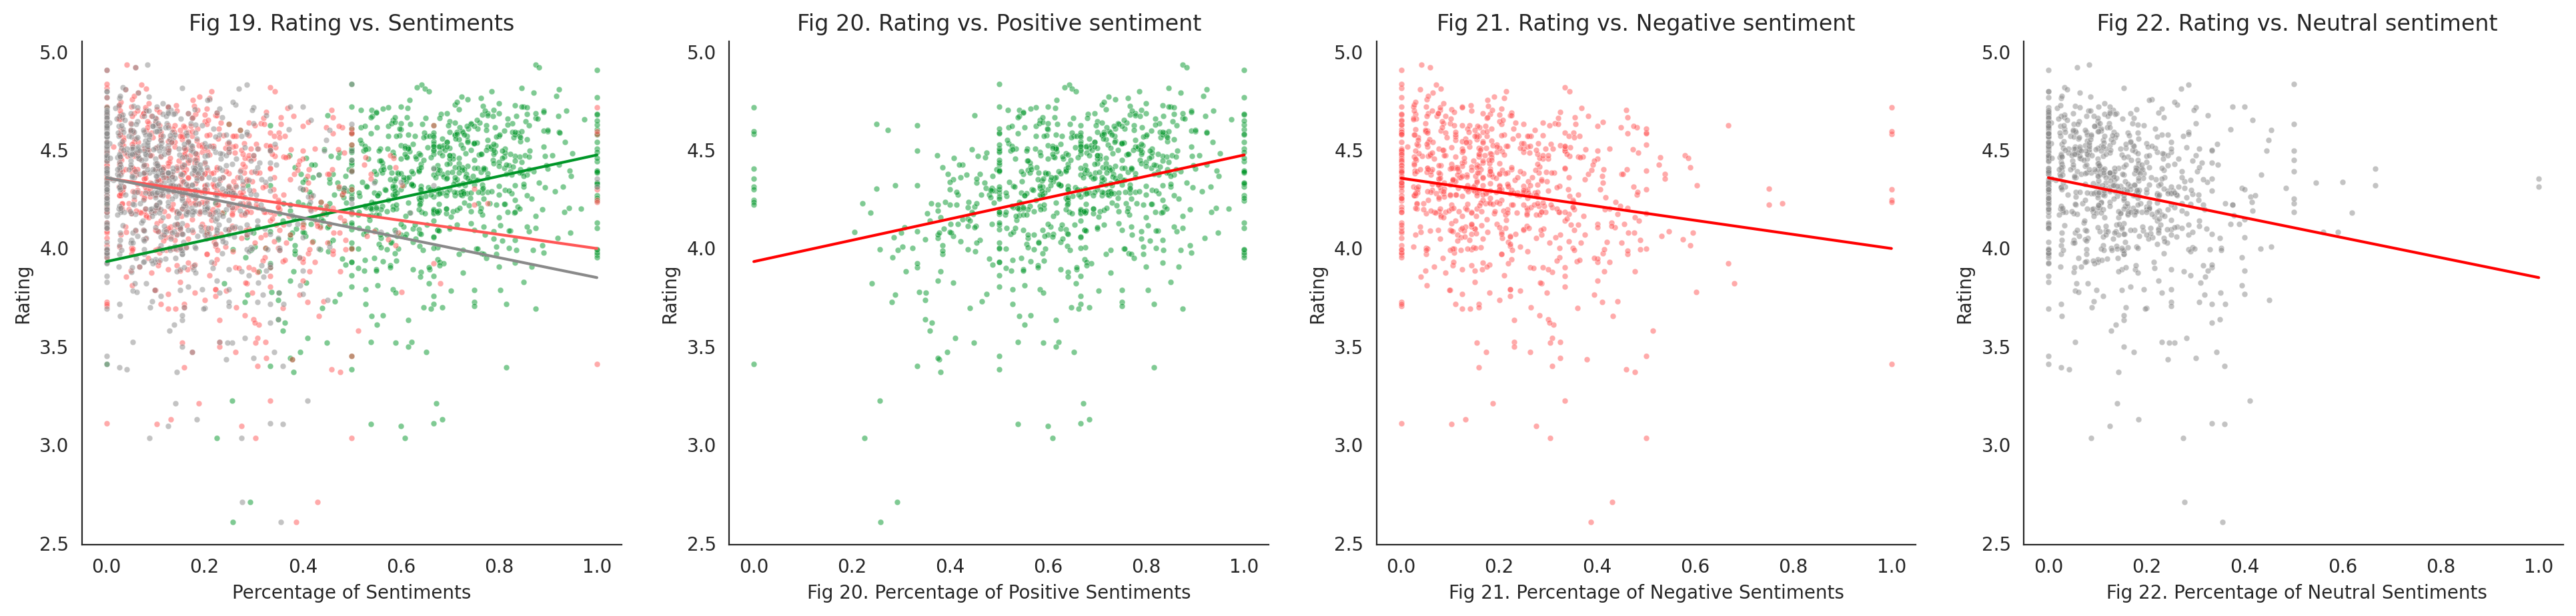

In [131]:
rating = app_review['Rating'] + np.random.normal(0, 0.03, size=len(app_review.Rating))

fig, ax_plot = plt.subplots(1,4, figsize=(24,5), dpi=200)

for col, ax, color, name, f in zip(['positive_perc','negative_perc','neutral_perc'], 
                                ax_plot[1:4], 
                                ['#009628','#FF5656', '#898989'], ['Positive','Negative','Neutral'],
                                ['Fig 20.', 'Fig 21.',' Fig 22.']):
  res = linregress(app_review[col], app_review['Rating'])
  fx = np.array([app_review[col].min(), app_review[col].max()])
  fy = res.intercept + res.slope * fx
  sns.scatterplot(app_review[col], rating, ax=ax, alpha=0.5, s=10, color=color)
  sns.lineplot(fx, fy, ax=ax, color='red')
  ax.set_xlabel(f"{f} Percentage of {name} Sentiments")
  ax.set_title(f"{f} Rating vs. {name} sentiment")
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  
  sns.scatterplot(app_review[col], rating, ax=ax_plot[0], alpha=0.5, s=10, color=color)
  sns.lineplot(fx, fy, ax=ax_plot[0], color=color)
  ax_plot[0].set_xlabel("Percentage of Sentiments")
  ax_plot[0].set_title("Fig 19. Rating vs. Sentiments")
  ax_plot[0].spines['top'].set_visible(False)
  ax_plot[0].spines['right'].set_visible(False)

Text here

In [133]:
def review_agg(df, new_df):

  """
  Takes a dataframe and an empty dataframe and concatinates reviews for each category and sentiment.

  Input:
  df - a dataframe
  new_df - an empty dataframe

  output:
  new_df - a dataframe with Category, Sentiment and Review as columns
  """

  for cat in ['DATING','ENTERTAINMENT','HOUSE_AND_HOME']:
    for sent in ['Positive','Negative']:
      df_sub = pd.DataFrame.from_dict({'Category':[cat],
                                    'Sentiment':[sent],
                                    'Review': [" ".join(df[(df.Category == cat) & (df.Sentiment == sent)].Translated_Review)]})
      new_df = pd.concat([new_df, df_sub], axis=0)
  
  return new_df

In [134]:
app_review = pd.merge(app_review, review, on='App', how='right')
cat_reviews = review_agg(app_review[['Category','Sentiment','Translated_Review']], pd.DataFrame()).dropna()
cat_reviews = cat_reviews.set_index(np.arange(0, len(cat_reviews))).pivot('Category','Sentiment','Review')

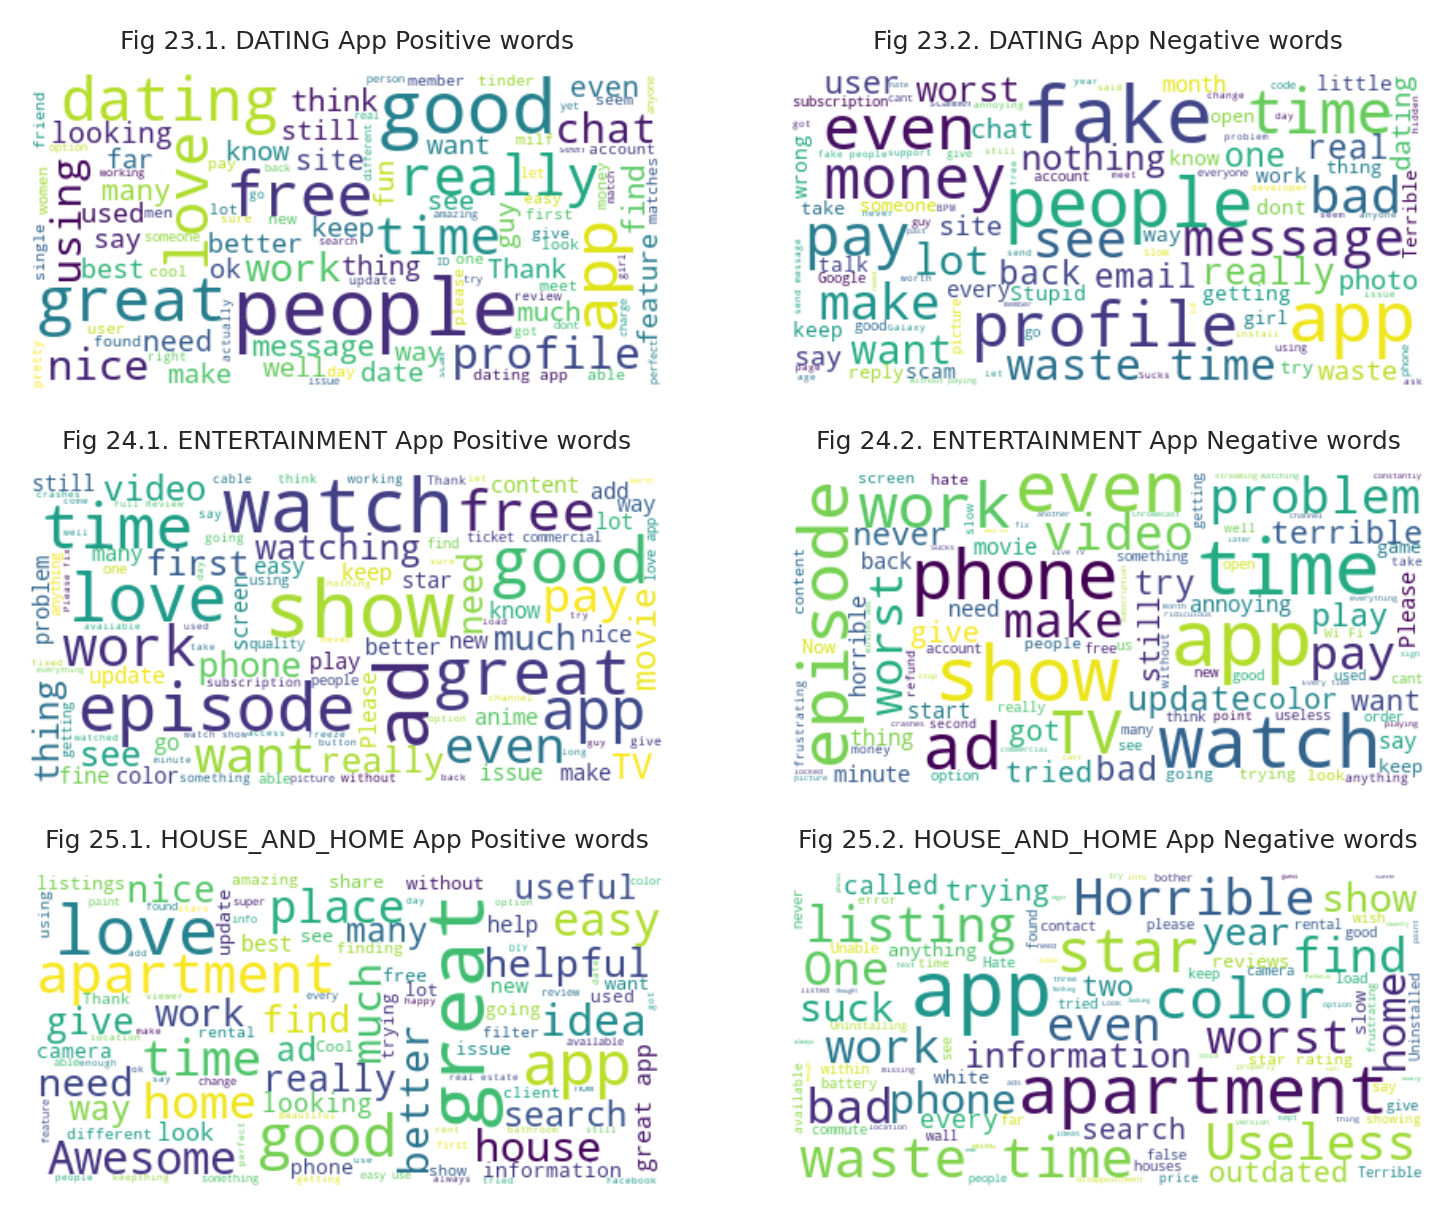

In [136]:
fig, axplots = plt.subplots(3,2, dpi=300, figsize=(6,5))

for row, ax, f in zip(cat_reviews.iterrows(), axplots, np.arange(23, 30)):
  row_values = row[1]
  wc0 = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(row_values.Positive)
  ax[0].imshow(wc0, interpolation='bilinear')
  ax[0].axis('off')
  ax[0].set_title(f"Fig {f}.1. {row[0]} App Positive words", fontsize=6)

  wc1 = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(row_values.Negative)
  ax[1].imshow(wc1, interpolation='bilinear')
  ax[1].axis('off')
  ax[1].set_title(f"Fig {f}.2. {row[0]} App Negative words", fontsize=6)

Text here

The End of the notebook